This notebook is created to illustrate the construction of hate speech detection using BERT model through ilustration of the daatset cleaning, BERT architecture building, model importing, model training and evaluation of the results

In [16]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizer
from dask.dataframe import DataFrame
import dask.dataframe as dd
import re
from babel.dates import format_time
import time
from transformers import AdamW
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt

Importing all libraries required to build the model, import the dataset, clean the dataset and evaluation of results.

In [4]:
# specify GPU
device = torch.device("cuda")

In [4]:

trainpanda=dd.read_csv('train_E6oV3lV.csv')
data=[]
for i in range(0,31962):

    x=trainpanda.loc[i,'tweet'].values
    f=x.compute()
    #this is cleaning a sample text extracted from the dataset using regex as requested.
    #
    cleaning = re.sub(r'[^\w\s\d#]', '', f[0])#remove anything that s not words, numbers or spaces
    #but not hashtags as they contain good information
    cleaning = re.sub(r'@\w+', '', cleaning)# removing @user (optional)
    #cleaning = re.sub(r'\s+', ' ', cleaning).strip()#removing whitespaces
    cleaning = re.sub(r'http\S+|www\S+|https\S+', '', cleaning)#removing urls
    cleaned = cleaning.encode('ascii', 'ignore').decode('ascii')#remove unicode characters
    data.append(cleaned)

cleaning the dataset using regex methods and other methods illustrated above and utilized from week 6 task.

In [5]:
data2=[]
def correct(word):
    # Apply the necessary correction logic to fix the word
    # Example: Replace 'q' with 'g'
    corrected_word = word.replace('user', "")   
    return corrected_word
for row in data:
    cleaner=row.replace('user', "")
    data2.append(cleaner)
label=trainpanda['label'].compute().tolist()
text=data2
refinedset=DataFrame.from_dict({'label':label,'tweet':text}, npartitions=2)
#refinedset.compute().to_csv("./refined", index=False)

In the next cell, the refined dataset is Loaded as it takes an hour to refine the dataset.

In [27]:
refinedset=dd.read_csv('refined')
label=refinedset['label'].compute().tolist()
text=refinedset['tweet'].compute().tolist()
refinedset=DataFrame.from_dict({'label':label,'tweet':text}, npartitions=2)
#refinedset.compute().to_csv("./refined", index=False)
refinedset.compute()

,label,tweet
0,0,when a father is dysfunctional and is so sel...
1,0,thanks for #lyft credit i cant use cause the...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide society now #motivation
...,...,...
31957,0,ate isz that youuu
31958,0,to see nina turner on the airwaves trying to...
31959,0,listening to sad songs on a monday morning otw...
31960,1,#sikh #temple vandalised in in #calgary #wso ...


in the next cell, the dataset is divivded into 70%-30% ratio for training and division respectively. the testing dataset is divivded into 50% validation and 50% testing.

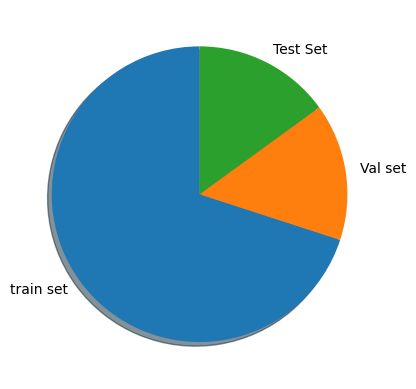

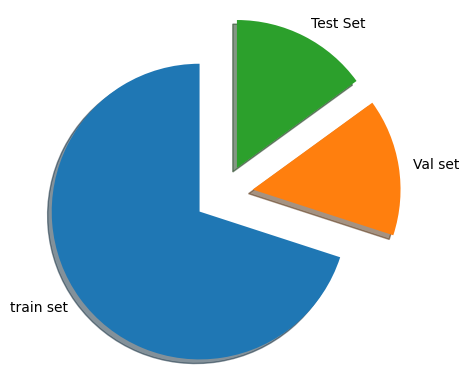

In [24]:
refinedset['label'].value_counts(normalize=True).head()

train_tweet, temp_text, train_labels, temp_labels = train_test_split(refinedset['tweet'], refinedset['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=refinedset['label'])

texttest=temp_text.compute().tolist()
testlabel=temp_labels.compute().tolist()
temp=DataFrame.from_dict({'label':testlabel,'tweet':texttest}, npartitions=2)

val_text, test_text, val_labels, test_labels = train_test_split(temp['tweet'], temp['label'], 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)


sizes=np.array([len(train_tweet), len(val_text),len(test_text)])
pltlabels=["train set","Val set", "Test Set"]
myexplode = [0.2, 0.2, 0.2]
plt.pie(sizes, labels=pltlabels, startangle = 90, shadow = True)
plt.show()
plt.pie(sizes, labels=pltlabels, startangle = 90, shadow = True, explode = myexplode)
plt.show()


loading BERT pretrained model and tokenizer. alongsdie this, a histogram of the length of the tweet is provided.

<AxesSubplot:>

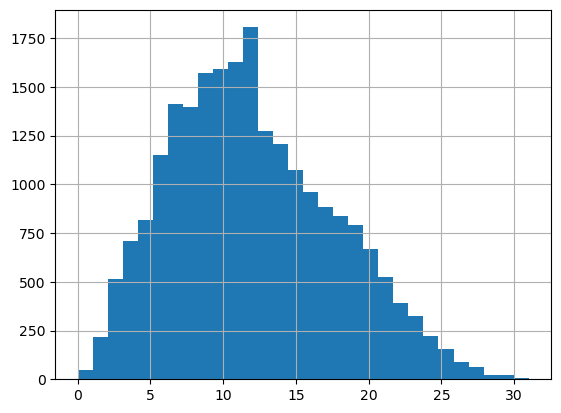

In [7]:
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
seq_len = [len(i.split()) for i in train_tweet]
pd.Series(seq_len).hist(bins = 30)


tokenize the training dataset, testing dataset and validation set.

In [10]:
tokens_train = tokenizer.batch_encode_plus(
    train_tweet.compute().tolist(),
    max_length = 25,
    padding=True,
    truncation=True
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.compute().tolist(),
    max_length = 25,
   padding=True,
    truncation=True
)
tokens_val = tokenizer.batch_encode_plus(
    val_text.compute().tolist(),
    max_length = 25,
    padding=True,
    truncation=True
)


converting the tokenized sets from lists to tensors thrpough creating tensor for the encoding sequence, tokenized mask and training, validation and testing set.

In [184]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.compute().tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.compute().tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.compute().tolist())

Defining some necessary parameters for the BERT model such as Batch size (which should be set according to GPU capability) and creating Dataloader for the datasets

In [163]:
batch_size = 32  #define a batch size
train_data = TensorDataset(train_seq, train_mask, train_y)# wrap tensors
train_sampler = RandomSampler(train_data)# sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)# dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)# wrap tensors
val_sampler = SequentialSampler(val_data)# sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)# dataLoader for validation set

Creating a class for the BERT architecture to specify and tailor its parameters such as specifying activation function and softmax activation function and passing the specified parameters to the created model.

In [164]:
for param in bert.parameters():
    param.requires_grad = False
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert 
        self.dropout = nn.Dropout(0.1)# dropout layer
        self.relu =  nn.ReLU()# relu activation function
        self.fc1 = nn.Linear(768,512) # dense layer 1
        self.fc2 = nn.Linear(512,2)# dense layer 2 (Output layer)
        self.softmax = nn.LogSoftmax(dim=1)#softmax activation function
    def forward(self, sent_id, mask):
        
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)# output layer
        x = self.softmax(x)# apply softmax activation

        return x

In the next cell, the pretrained cell is passed to the predefined parameters/architecture and the model is pushed to GPU to be able to train it.

In [165]:
###########pass the pre-trained BERT to our define architecture###################
model = BERT_Arch(bert)
model = model.to(device)# push the model to GPU
optimizer = torch.optim.AdamW(model.parameters(),lr = 1e-5)# define the optimizer 

weight of each class in the datset was calculated (labels)

In [166]:
#compute the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
print("Class Weights:",class_weights)
weights= torch.tensor(class_weights,dtype=torch.float)# converting list of class weights to a tensor
weights = weights.to(device)# push to GPU
cross_entropy  = nn.NLLLoss(weight=weights)# define the loss function
epochs = 15# number of training epochs

Class Weights: [0.53770909 7.12970045]


in the next cell, the training function was created which uses the training dataset divided as random batches of size 32 and feed it to the model to update its weights and it keeps reiterating for a defined number of epochs. it keeps track of the loss and total accuracy percentage as the total loss percentage (error) should converge each epoch. to minimise the error, the function does a backward pass or a backpropagaion method to calculate the gradients (refine the weights of each node) to improve accuracy.

In [167]:
# function to train the model
def training():   
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds=[] # empty list to save model predictions  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):                
        if step % 50 == 0 and not step == 0:# progress update after every 50 batches.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))                
        batch = [r.to(device) for r in batch]# push the batch to gpu
        sent_id, mask, labels = batch          
        model.zero_grad()# clear previously calculated gradients        
        preds = model(sent_id, mask)# get model predictions for the current batch        
        loss = cross_entropy(preds, labels)# compute the loss between actual and predicted values        
        total_loss = total_loss + loss.item()# add on to the total loss        
        loss.backward()# backward pass to calculate the gradients        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)# clip the the gradients to 1.0. It helps in preventing the exploding gradient problem        
        optimizer.step()# update parameters        
        preds=preds.detach().cpu().numpy()# model predictions are stored on GPU. So, push it to CPU    
    total_preds.append(preds)# append the model predictions   
    avg_loss = total_loss / len(train_dataloader)# compute the training loss of the epoch  
      # predictions are in the form of (no. of batches, size of batch, no. of classes).      
    total_preds  = np.concatenate(total_preds, axis=0)# reshape the predictions in form of (number of samples, no. of classes)    
    return avg_loss, total_preds#returns the loss and predictions

This function is created to evaluate the models performance during each epoch to identify the best result the model has reached and ave it  automatically.

In [168]:
################function for evaluating the model####################
def evaluation():          
    # deactivate dropout layers
    model.eval()
    total_loss, total_accuracy = 0, 0        
    total_preds = []# empty list to save the model predictions
    print("\nEvaluating...")
    # iterate over batches
    for step,batch in enumerate(val_dataloader):               
        if step % 50 == 0 and not step == 0: # Progress update every 50 batches.                        
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))# Report progress.        
        batch = [t.to(device) for t in batch]# push the batch to gpu
        sent_id, mask, labels = batch
        # deactivate autograd
        with torch.no_grad():            
            # model predictions
            preds = model(sent_id, mask)
            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)    
    avg_loss = total_loss / len(val_dataloader) # compute the validation loss of the epoch   
    total_preds  = np.concatenate(total_preds, axis=0) # reshape the predictions in form of (number of samples, no. of classes)
    return avg_loss, total_preds

In [20]:
#######################running the training and evaluation functions to train the model#########
best_valid_loss = float('inf')# set initial loss to infinite
train_losses=[]# empty lists to store training loss of each epoch
valid_losses=[]# empty lists to store validation loss of each epoch
#for each epoch
for epoch in range(epochs):   
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))        
    train_loss, _ = training()#train model        
    valid_loss, _ = evaluation()#evaluate model       
    if valid_loss < best_valid_loss: #save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 15
  Batch    50  of    700.
  Batch   100  of    700.
  Batch   150  of    700.
  Batch   200  of    700.
  Batch   250  of    700.
  Batch   300  of    700.
  Batch   350  of    700.
  Batch   400  of    700.
  Batch   450  of    700.
  Batch   500  of    700.
  Batch   550  of    700.
  Batch   600  of    700.
  Batch   650  of    700.

Evaluating...
  Batch    50  of    150.
  Batch   100  of    150.

Training Loss: 0.668
Validation Loss: 0.635

 Epoch 2 / 15
  Batch    50  of    700.
  Batch   100  of    700.
  Batch   150  of    700.
  Batch   200  of    700.
  Batch   250  of    700.
  Batch   300  of    700.
  Batch   350  of    700.
  Batch   400  of    700.
  Batch   450  of    700.
  Batch   500  of    700.
  Batch   550  of    700.
  Batch   600  of    700.
  Batch   650  of    700.

Evaluating...
  Batch    50  of    150.
  Batch   100  of    150.

Training Loss: 0.634
Validation Loss: 0.595

 Epoch 3 / 15
  Batch    50  of    700.
  Batch   100  of    700.
  B

After saving the best and most accurate model trained, we load it to test it with the testing dataset

In [178]:
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

due to GPU memory insufficiency, i had to decrease the testing dataset number to 1000 instead of 4792. the following cell shows the predicitions made by the trained model, their accuracy, their precision and recall score.

In [186]:
l=1000
testerseq=test_seq[0:l][:]
testermask=test_mask[0:l][:]

with torch.no_grad():
    preds = model(testerseq.to(device), testermask.to(device))
    preds = preds.detach().cpu().numpy()
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y[0:l], preds))


              precision    recall  f1-score   support

           0       0.97      0.85      0.90       926
           1       0.27      0.70      0.39        74

    accuracy                           0.83      1000
   macro avg       0.62      0.77      0.65      1000
weighted avg       0.92      0.83      0.87      1000



The following cell shows the amount of available GPU memory making it harder to predict for all testing dataset.

In [49]:
import torch

# Check the maximum GPU memory allocated
max_allocated = torch.cuda.max_memory_allocated(device=device)  # 'device=None' refers to the current device

# Check the maximum GPU memory cached
max_cached = torch.cuda.max_memory_cached(device=device)

# Calculate the amount of free memory
free_memory = torch.cuda.get_device_properties(0).total_memory - max_allocated

# Print the results
print(f"Maximum GPU Memory Allocated: {max_allocated / 1024 ** 2:.2f} MB")
print(f"Maximum GPU Memory Cached: {max_cached / 1024 ** 2:.2f} MB")
print(f"Free GPU Memory: {free_memory / 1024 ** 2:.2f} MB")



Maximum GPU Memory Allocated: 2810.21 MB
Maximum GPU Memory Cached: 3528.00 MB
Free GPU Memory: 1285.66 MB


Take into consideration that to increase model accuracy, more training needs to be implemented. not only 15 epochs but more.

In [190]:
######################now let us test the model by entering a sentence and observing its result####################

tweeter=[]
msg=input()
print('and this is supposed to be hate or love? 0 is normal and 1 is hate')# this question is just to provide the classification report
testing=input()#no matter what the user puts in this input it doesn't affect the prediction
testinglist=[]
testinglist.append(int(testing))
tweeter.append(msg)
tokener = tokenizer.batch_encode_plus(
    tweeter,
    max_length = 25,
   pad_to_max_length=True,
    truncation=True
)
test_seq = torch.tensor(tokener['input_ids'])
test_mask = torch.tensor(tokener['attention_mask'])
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()
preds = np.argmax(preds, axis = 1)
print(classification_report(torch.tensor(testinglist), preds))


love
and this is supposed to be hate or love? 0 is normal and 1 is hate
0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



C:\Users\20101\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [189]:
preds

array([1], dtype=int64)